In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import keras 
import tensorflow as tf
from keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa 
import cv2
import pandas as pd 
import ntpath 
import random

In [8]:
# Load Train Data

datadir = "data"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

C:\Users\YSH\AppData\Local\Temp/ipykernel_12796/1581048176.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_526.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_526.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_526.jpg,0.00,0.0,0,5.951196
1,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_598.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_598.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_598.jpg,0.00,0.0,0,5.903379
2,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_670.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_670.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_670.jpg,0.00,0.0,0,5.855948
3,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_737.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_737.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_737.jpg,0.00,0.0,0,5.820624
4,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_809.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_809.jpg,C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_809.jpg,-0.05,0.0,0,5.785095


## Image Path Edit

Split the src of the image to load image appropriate.

In [18]:
def path_leaf(path): 
    head, tail = ntpath.split(path)
    return tail

In [17]:
print(path_leaf('C:/Users/YSH/Documents/OurAICar/simulation/simple/data/IMG/center_2022_02_22_12_44_40_809.jpg'))

C:/Users/YSH/Documents/OurAICar/simulation/simple/data/IMG center_2022_02_22_12_44_40_809.jpg
('C:/Users/YSH/Documents/OurAICar/simulation/simple/data/IMG', 'center_2022_02_22_12_44_40_809.jpg')


In [19]:
data["center"] = data["center"].apply(path_leaf)
data["left"] = data["left"].apply(path_leaf)
data["right"] = data["right"].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_02_22_12_44_40_526.jpg,left_2022_02_22_12_44_40_526.jpg,right_2022_02_22_12_44_40_526.jpg,0.00,0.0,0,5.951196
1,center_2022_02_22_12_44_40_598.jpg,left_2022_02_22_12_44_40_598.jpg,right_2022_02_22_12_44_40_598.jpg,0.00,0.0,0,5.903379
2,center_2022_02_22_12_44_40_670.jpg,left_2022_02_22_12_44_40_670.jpg,right_2022_02_22_12_44_40_670.jpg,0.00,0.0,0,5.855948
3,center_2022_02_22_12_44_40_737.jpg,left_2022_02_22_12_44_40_737.jpg,right_2022_02_22_12_44_40_737.jpg,0.00,0.0,0,5.820624
4,center_2022_02_22_12_44_40_809.jpg,left_2022_02_22_12_44_40_809.jpg,right_2022_02_22_12_44_40_809.jpg,-0.05,0.0,0,5.785095


## Train Data Optimization

Data distribution is distorted and we have to optimize it

In [21]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data["steering"], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5

total data: 3005


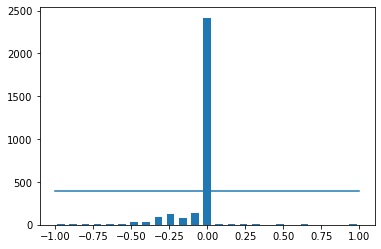

In [22]:
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))
print(f"total data: {len(data)}")

In [23]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j+1]:
            list_.append(i)
            
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

In [24]:
print(f"removed: {len(remove_list)}")
data.drop(data.index[remove_list], inplace=True)
print(f"remaining: {len(data)}")

removed: 2017
remaining: 988


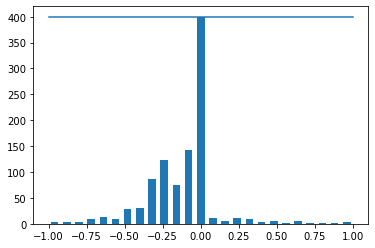

In [25]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

In [26]:
print(data.iloc[1])

center      center_2022_02_22_12_44_40_879.jpg
left        left_2022_02_22_12_44_40_879.jpg  
right       right_2022_02_22_12_44_40_879.jpg 
steering   -0.25                              
throttle    0.0                               
reverse     0                                 
speed       5.726951                          
Name: 5, dtype: object


## Load Image

Loading Image and Augment it to extend dataset.